In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import glob
import pymeshlab as pml

### Calibration

In [113]:
CHESSBOARD_CORNER_NUM_X = 8
CHESSBOARD_CORNER_NUM_Y = 6

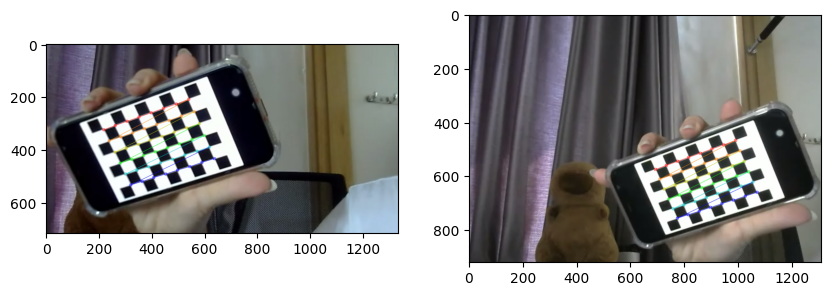

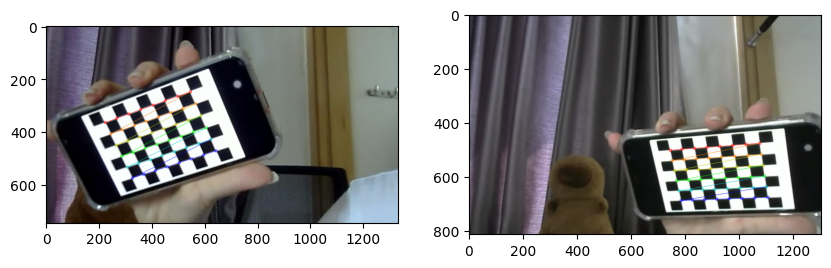

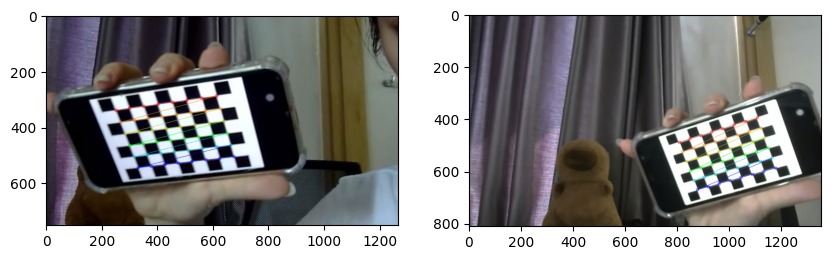

In [114]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
objp = np.zeros((CHESSBOARD_CORNER_NUM_X*CHESSBOARD_CORNER_NUM_Y,3), np.float32)
objp[:,:2] = np.mgrid[0:CHESSBOARD_CORNER_NUM_X*40:40,0:CHESSBOARD_CORNER_NUM_Y*40:40].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpointsL = [] # 2d points in image plane.
imgpointsR = [] # 2d points in image plane.

imagesLeft = glob.glob('./calibration/left/*.png')
imagesRight = glob.glob('./calibration/right/*.png')

for imgLeft, imgRight in zip(imagesLeft, imagesRight):
    imgL = cv2.imread(imgLeft)
    imgR = cv2.imread(imgRight)
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    retL, cornersL = cv2.findChessboardCorners(grayL, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)
    retR, cornersR = cv2.findChessboardCorners(grayR, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)
    # If found, add object points, image points (after refining them)
    if retL and retR == True:
        objpoints.append(objp)

        cornersL = cv2.cornerSubPix(grayL,cornersL, (11,11), (-1,-1), criteria)
        imgpointsL.append(cornersL)
        cornersR = cv2.cornerSubPix(grayR,cornersR, (11,11), (-1,-1), criteria)
        imgpointsR.append(cornersR)

        # Draw and display the corners
        cv2.drawChessboardCorners(imgL, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), cornersL, retL)
        cv2.drawChessboardCorners(imgR, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), cornersR, retR)
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(imgL[:,:,::-1])
        plt.subplot(1,2,2)
        plt.imshow(imgR[:,:,::-1])

In [115]:
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints, imgpointsL, grayL.shape[::-1], None, None)
print(f"Left camera\nMatrix: \n{mtxL}\nDistortion coefficients : \n{distL}")
heightL, widthL, channelsL = imgL.shape
newCameraMatrixL, roiL = cv2.getOptimalNewCameraMatrix(mtxL, distL, (widthL, heightL), 1, (widthL, heightL))
print()

retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints, imgpointsR, grayR.shape[::-1], None, None)
print(f"Right camera\nMatrix is \n{mtxR}\nDistortion coefficients : \n{distR}")
heightR, widthR, channelsR = imgR.shape
newCameraMatrixR, roiR = cv2.getOptimalNewCameraMatrix(mtxR, distR, (widthR, heightR), 1, (widthR, heightR))

Left camera
Matrix: 
[[2.23432412e+03 0.00000000e+00 4.62393768e+02]
 [0.00000000e+00 2.14972654e+03 4.12508729e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients : 
[[-3.64005250e-01  9.29769509e+01 -1.13539267e-02 -8.93854878e-03
  -6.92953553e+03]]

Right camera
Matrix is 
[[2.04502205e+03 0.00000000e+00 4.76480581e+02]
 [0.00000000e+00 2.01337126e+03 3.78296126e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients : 
[[-0.11176229  2.02219963 -0.02333131  0.01043679 -6.07818592]]


In [116]:
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC
criteria_stereo = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 30, 1e-6)
retStereo, newCameraMatrixL, distL, newCameraMatrixR, distR, R, T, essentialMatrix, fundamentalMatrix = cv2.stereoCalibrate(objpoints, imgpointsL, imgpointsR, newCameraMatrixL, distL, newCameraMatrixR, distR, grayL.shape[::-1], criteria_stereo, flags)

In [117]:
rectifyScale = 1
rectL, rectR, projMatrixL, projMatrixR, Q, roiL, roiR = cv2.stereoRectify(
    newCameraMatrixL, distL, newCameraMatrixR, distR, grayL.shape[::-1], R, T, rectifyScale, (0, 0))
print(projMatrixL, projMatrixR, Q, sep='\n')

[[1.86397341e+03 0.00000000e+00 4.15098087e+02 0.00000000e+00]
 [0.00000000e+00 1.86397341e+03 4.65461965e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
[[1.86397341e+03 0.00000000e+00 4.15098087e+02 2.65323244e+06]
 [0.00000000e+00 1.86397341e+03 4.65461965e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -4.15098087e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -4.65461965e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.86397341e+03]
 [ 0.00000000e+00  0.00000000e+00 -7.02529257e-04  0.00000000e+00]]


In [118]:
params = {
    "color_intrinsics": {
        "width": widthL,
        "height": heightL,
        "fx": float(mtxL[0][0]),
        "fy": float(mtxL[1][1]),
        "ppx": float(mtxL[0][2]),
        "ppy": float(mtxL[1][2]),
        "coeffs": distL.tolist()
    },
    "depth_intrinsics": {
        "width": widthL,
        "height": heightL,
        "fx": float(projMatrixL[0][0]),
        "fy": float(projMatrixL[1][1]),
        "ppx": float(projMatrixL[0][2]),
        "ppy": float(projMatrixL[1][2]),
        "coeffs": distL.tolist()
    },
    "extrinsics": {
        "rotation": R.tolist(),
        "translation": T.tolist()
    }
}

with open("camera_params.json", "w") as f:
    json.dump(params, f, indent=4)

### Depth Map

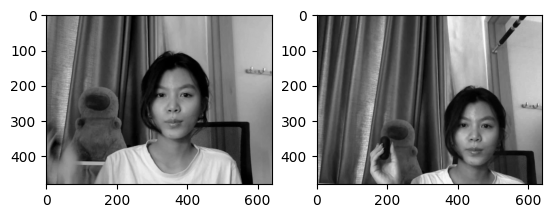

In [119]:
imgL = cv2.imread('frames/left/1.png', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('frames/right/1.png', cv2.IMREAD_GRAYSCALE)

plt.subplot(1,2,1)
plt.imshow(imgL, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(imgR, cmap='gray')

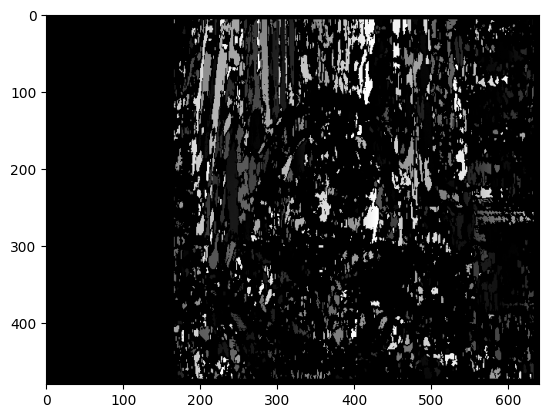

In [103]:
NUM_DISPARITIES = 10
BLOCK_SIZE = 15
stereo = cv2.StereoBM_create(numDisparities=16*NUM_DISPARITIES, blockSize=BLOCK_SIZE)
disparity = stereo.compute(imgL,imgR)
cv2.imwrite('depth.png',disparity)
plt.imshow(disparity, cmap='gray')

In [90]:
with open("camera_params.json", 'r') as f:
    params = json.load(f)

color_intrinsics = params["color_intrinsics"]
fx_color = color_intrinsics["fx"]
fy_color = color_intrinsics["fy"]
ppx_color = color_intrinsics["ppx"]
ppy_color = color_intrinsics["ppy"]

depth_intrinsics = params["depth_intrinsics"]
fx_depth = depth_intrinsics["fx"]
fy_depth = depth_intrinsics["fy"]
ppx_depth = depth_intrinsics["ppx"]
ppy_depth = depth_intrinsics["ppy"]

R = np.array(params["extrinsics"]["rotation"]).reshape(3, 3)
t = np.array(params["extrinsics"]["translation"]).reshape(3, 1)


In [95]:
depth_scale = 1000.0
color_img = cv2.imread('frames/left/8.png')
color_img_rgb = cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB)
depth_img = cv2.imread("depth.png", cv2.IMREAD_UNCHANGED)
depth = depth_img.astype(np.float32) / depth_scale

h, w = depth.shape
x_coords, y_coords = np.meshgrid(np.arange(w), np.arange(h))
X_depth = (x_coords - ppx_depth) * depth / fx_depth
Y_depth = (y_coords - ppy_depth) * depth / fy_depth
Z_depth = depth

In [96]:
points_depth = np.stack((X_depth, Y_depth, Z_depth), axis=-1)
points_depth_flat = points_depth.reshape(-1, 3).T
points_color_flat = (R @ points_depth_flat) + t
points_color = points_color_flat.T.reshape(h, w, 3)

points_color_flat = points_color.reshape(-1, 3)
valid_mask = points_color_flat[:, 2] > 0

points_color_valid = points_color_flat[valid_mask]

Xc = points_color_valid[:, 0]
Yc = points_color_valid[:, 1]
Zc = points_color_valid[:, 2]
u = np.round(fx_color * (Xc / Zc) + ppx_color).astype(np.int32)
v = np.round(fy_color * (Yc / Zc) + ppy_color).astype(np.int32)

valid_proj = (u >= 0) & (u < color_img_rgb.shape[1]) & (v >= 0) & (v < color_img_rgb.shape[0])
points_color_valid = points_color_valid[valid_proj]
u = u[valid_proj]
v = v[valid_proj]

colors = color_img_rgb[v, u, :]
colors_normalized = colors / 255.0

In [97]:
with open("output.ply", 'wb') as f:
    # Write header
    f.write(b'ply\n')
    f.write(b'format binary_little_endian 1.0\n')
    f.write(f'element vertex {points_color_valid.shape[0]}\n'.encode())
    f.write(b'property float x\n')
    f.write(b'property float y\n')
    f.write(b'property float z\n')
    f.write(b'property uchar red\n')
    f.write(b'property uchar green\n')
    f.write(b'property uchar blue\n')
    f.write(b'end_header\n')

    # Convert data to structured array
    vertex_dtype = np.dtype([
        ('x', np.float32),
        ('y', np.float32),
        ('z', np.float32),
        ('red', np.uint8),
        ('green', np.uint8),
        ('blue', np.uint8)
    ])

    # Create structured array
    vertices = np.empty(points_color_valid.shape[0], dtype=vertex_dtype)
    vertices['x'] = points_color_valid[:, 0]
    vertices['y'] = points_color_valid[:, 1]
    vertices['z'] = points_color_valid[:, 2]
    vertices['red'] = colors[:, 2]
    vertices['green'] = colors[:, 1]
    vertices['blue'] = colors[:, 0]

    # Write data
    vertices.tofile(f)

In [98]:
ms = pml.MeshSet()
ms.load_new_mesh("output.ply")
ms.show_polyscope()